In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [81]:
df= pd.read_csv("Loan dataset_classification.csv")

df = df.dropna(subset=["Loan_Status"])

X = df.drop(columns=["Loan_Status","Loan_ID","Gender","Dependents"])
y = df["Loan_Status"].map({"Y":1,"N":0})
print(y.shape)
print(y.isna().sum())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

(614,)
0


In [82]:
log_cols = ["ApplicantIncome", "CoapplicantIncome"] 
num_cols = [ "LoanAmount", "Credit_History","Loan_Amount_Term"]
cat_cols = [ "Married", "Self_Employed","Education","Property_Area"]

In [83]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

log_numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p, validate=False)),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

In [84]:
preprocessor = ColumnTransformer([
    ("log_num", log_numeric_pipeline, log_cols),
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# class DataSetValidator(BaseEstimator, TransformerMixin):

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         if (0 < X["Credit_History"] < 3).any():
#             raise ValueError("Credit_History should be between 0 to 3")
#         if (X["ApplicantIncome"] < 0).any():
#             raise ValueError("ApplicantIncome cannot be negative")
#         return X


model_pipeline = Pipeline([
    #("credit_history_validation", DataSetValidator()),
    ("preprocess", preprocessor),
    ("model", LogisticRegression(class_weight="balanced",max_iter=3000))
])

Accuracy: 0.7317073170731707


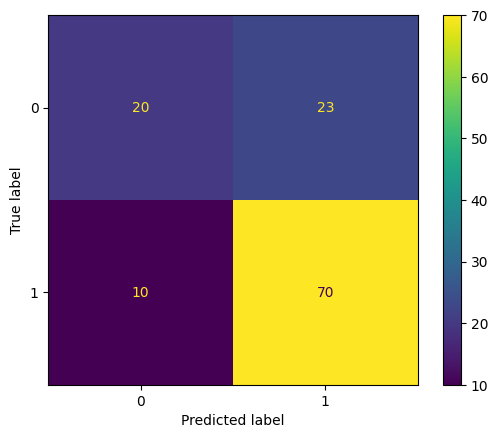

In [85]:
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [86]:
test_data = {
    "Married": "No",
    "Education": "Not Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 6500,
    "CoapplicantIncome": 1100,
    "LoanAmount": 2100,
    "Loan_Amount_Term": 360,
    "Credit_History": 3,
    "Property_Area": "Rural"
}

try:
    if test_data["Credit_History"] < 0:
        raise ValueError("Credit_History cannot be negative")

    test_df = pd.DataFrame([test_data])

    model = model_pipeline
    prediction = model.predict(test_df)

    print("Prediction:", prediction)
    if prediction[0] == 1:
        print("Loan Approved")
    else:
        print("Loan Rejected")
except ValueError as ve:
    print("Validation Error:", ve)

Prediction: [1]
Loan Approved


In [87]:
test_data = {
    "Married": "No",
    "Education": "Not Graduate",
    "Self_Employed": "No",
    "ApplicantIncome": 6500,
    "CoapplicantIncome": 1100,
    "LoanAmount": 2200,
    "Loan_Amount_Term": 360,
    "Credit_History": 3,
    "Property_Area": "Rural"
}
try:
    if test_data["Credit_History"] < 0:
        raise ValueError("Credit_History cannot be negative")

    test_df = pd.DataFrame([test_data])

    model = model_pipeline
    prediction = model.predict(test_df)

    print("Prediction:", prediction)
    if prediction[0] == 1:
        print("Loan Approved")
    else:
        print("Loan Rejected")

except ValueError as ve:
    print("Validation Error:", ve)
 

Prediction: [0]
Loan Rejected


In [88]:
model_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('log_num', ...), ('num', ...), ...]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [89]:
!pip install joblib

In [90]:
import joblib

In [91]:
joblib.dump(model_pipeline, "loan_pretrained.pkl")

['loan_pretrained.pkl']

In [92]:
from flask import Flask, jsonify, request, render_template
import pandas as pd

app = Flask(__name__)

model_pipeline_loaded = joblib.load("loan_pretrained.pkl")
@app.route('/')
def home():
    return render_template('form.html')

@app.route("/predict", methods=["POST"])
def predict():

    data = request.get_json()
    df= pd.DataFrame(data, index=[0])
    prediction = model_pipeline_loaded.predict(df)
    print(prediction)
    return jsonify({       
        "predicted_output": int(prediction[0])
    })
app.run(port=5000, debug=False, use_reloader=False)

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


127.0.0.1 - - [27/Jan/2026 15:49:36] "POST /predict HTTP/1.1" 200 -


[1]
 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

c:\Users\thriam\WorkSpaces\mercml\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
